In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
sys.path.append('../')
from data_lib import MusicDeepFakeDataset, model_labels, train_set, test_files
import params
import utils

REPO_ROOT = '/home/navin/repos/FakeMusicCaps'
FIGURES_DIR = os.path.join(REPO_ROOT, 'figures')



## Balance of classes

In [2]:
from params import PARENT_DIR

fakemusiccaps_dir = os.path.join(PARENT_DIR, 'data', 'FakeMusicCaps')

# List all subdirectories in FakeMusicCaps
main_subdirs = [d for d in os.listdir(fakemusiccaps_dir) if os.path.isdir(os.path.join(fakemusiccaps_dir, d))]

for main_dir in main_subdirs:
    print(f"\n{main_dir}/")
    main_path = os.path.join(fakemusiccaps_dir, main_dir)
    
    # Count WAV files in this directory
    wav_files = len([f for f in os.listdir(main_path) if f.endswith('.wav')])
    if wav_files > 0:
        print(f"  WAV files in root: {wav_files}")
    
    # List subdirectories and their WAV files
    subdirs = [d for d in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, d))]
    for subdir in subdirs:
        subdir_path = os.path.join(main_path, subdir)
        num_files = len([f for f in os.listdir(subdir_path) if f.endswith('.wav')])
        print(f"  {subdir}/: {num_files} wav files")


MusicCaps/
  WAV files in root: 5373

SunoCaps/
  WAV files in root: 63

musicldm/
  WAV files in root: 5521

mustango/
  WAV files in root: 5521

MusicGen_medium/
  WAV files in root: 5521

stable_audio_open/
  WAV files in root: 5521

audioldm2/
  WAV files in root: 5521


## Visualize raw audio waveforms of each class

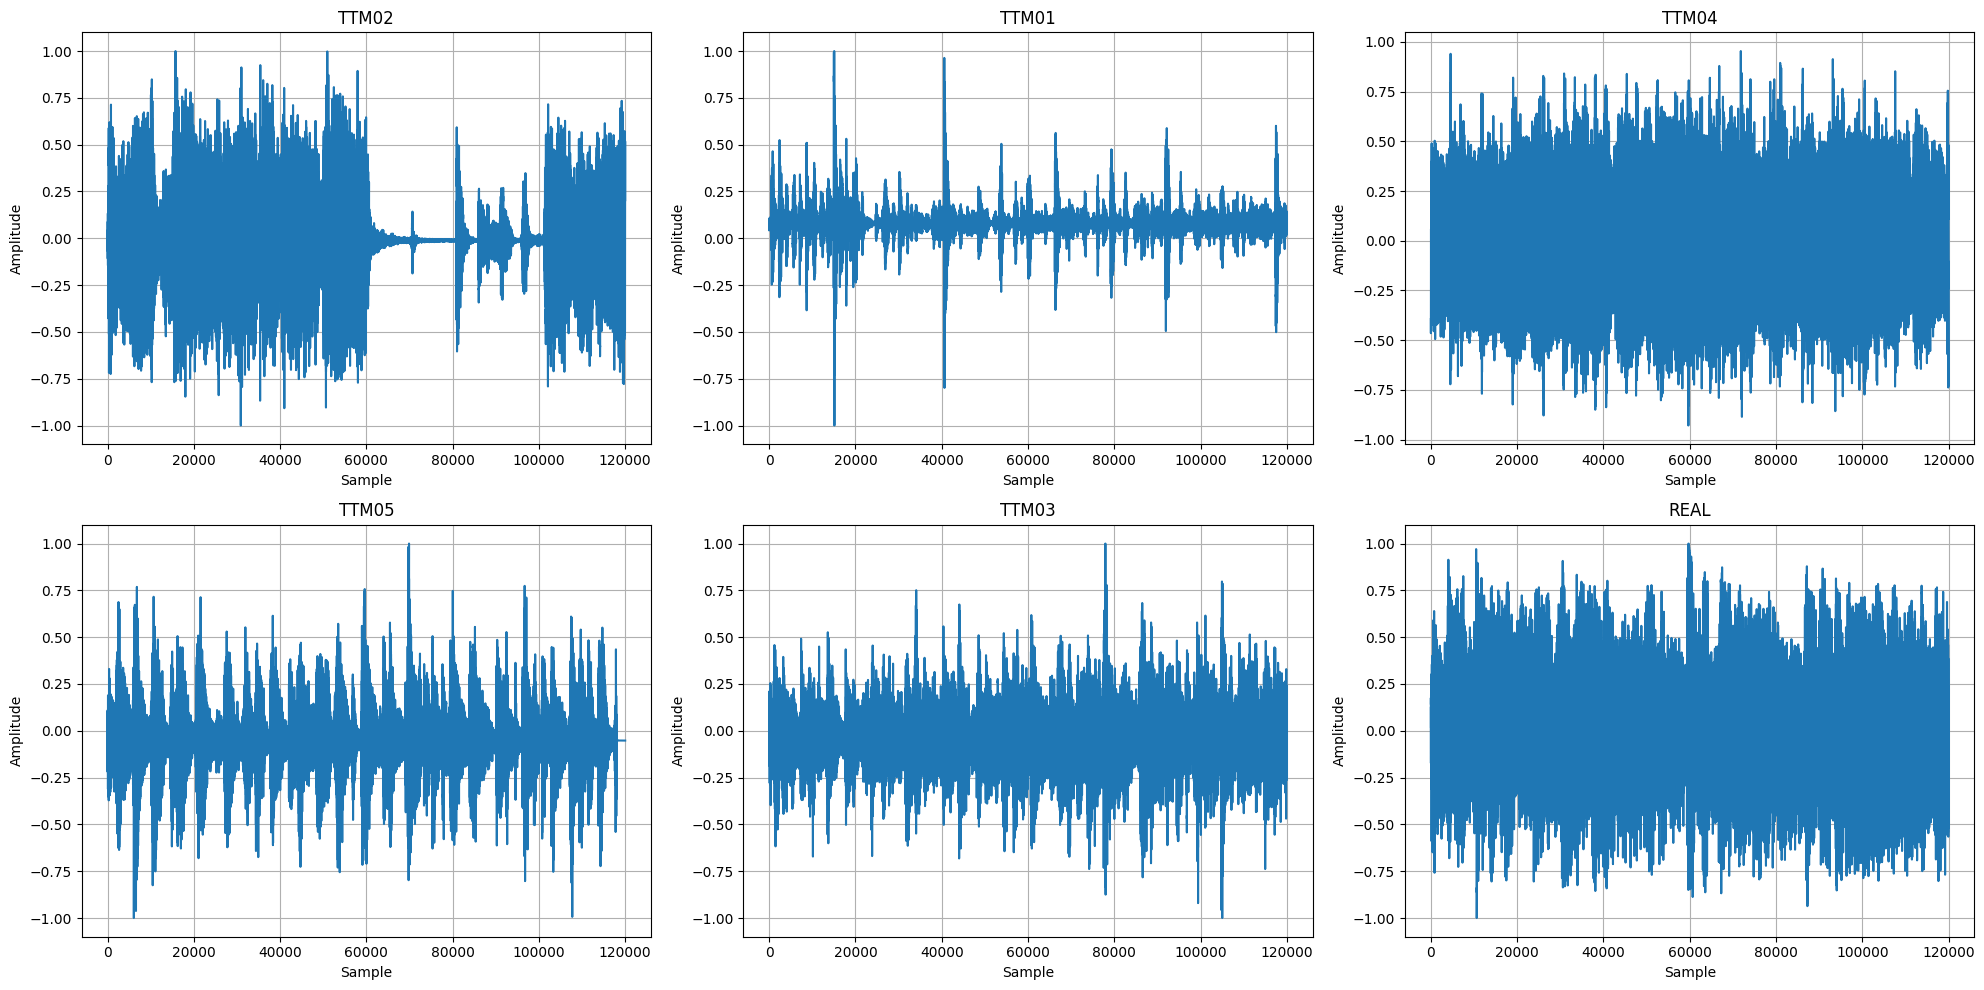

In [3]:
# Create dataset for raw audio
raw_dataset = MusicDeepFakeDataset(train_set, model_labels, 7.5, feat_type='raw')

# Get one example from each class
classes = ['REAL', 'TTM01', 'TTM02', 'TTM03', 'TTM04', 'TTM05']
examples = {}

for i, (data, label) in enumerate(raw_dataset):
    class_idx = int(label.item())
    class_name = classes[class_idx]
    if class_name not in examples:
        examples[class_name] = data
    if len(examples) == len(classes):
        break

# Plot waveforms in a grid
plt.figure(figsize=(20, 10))
for i, (class_name, wave) in enumerate(examples.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(wave.squeeze())
    plt.title(f"{class_name}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.tight_layout()
plt.show()

## Visualize log spectrograms of each class

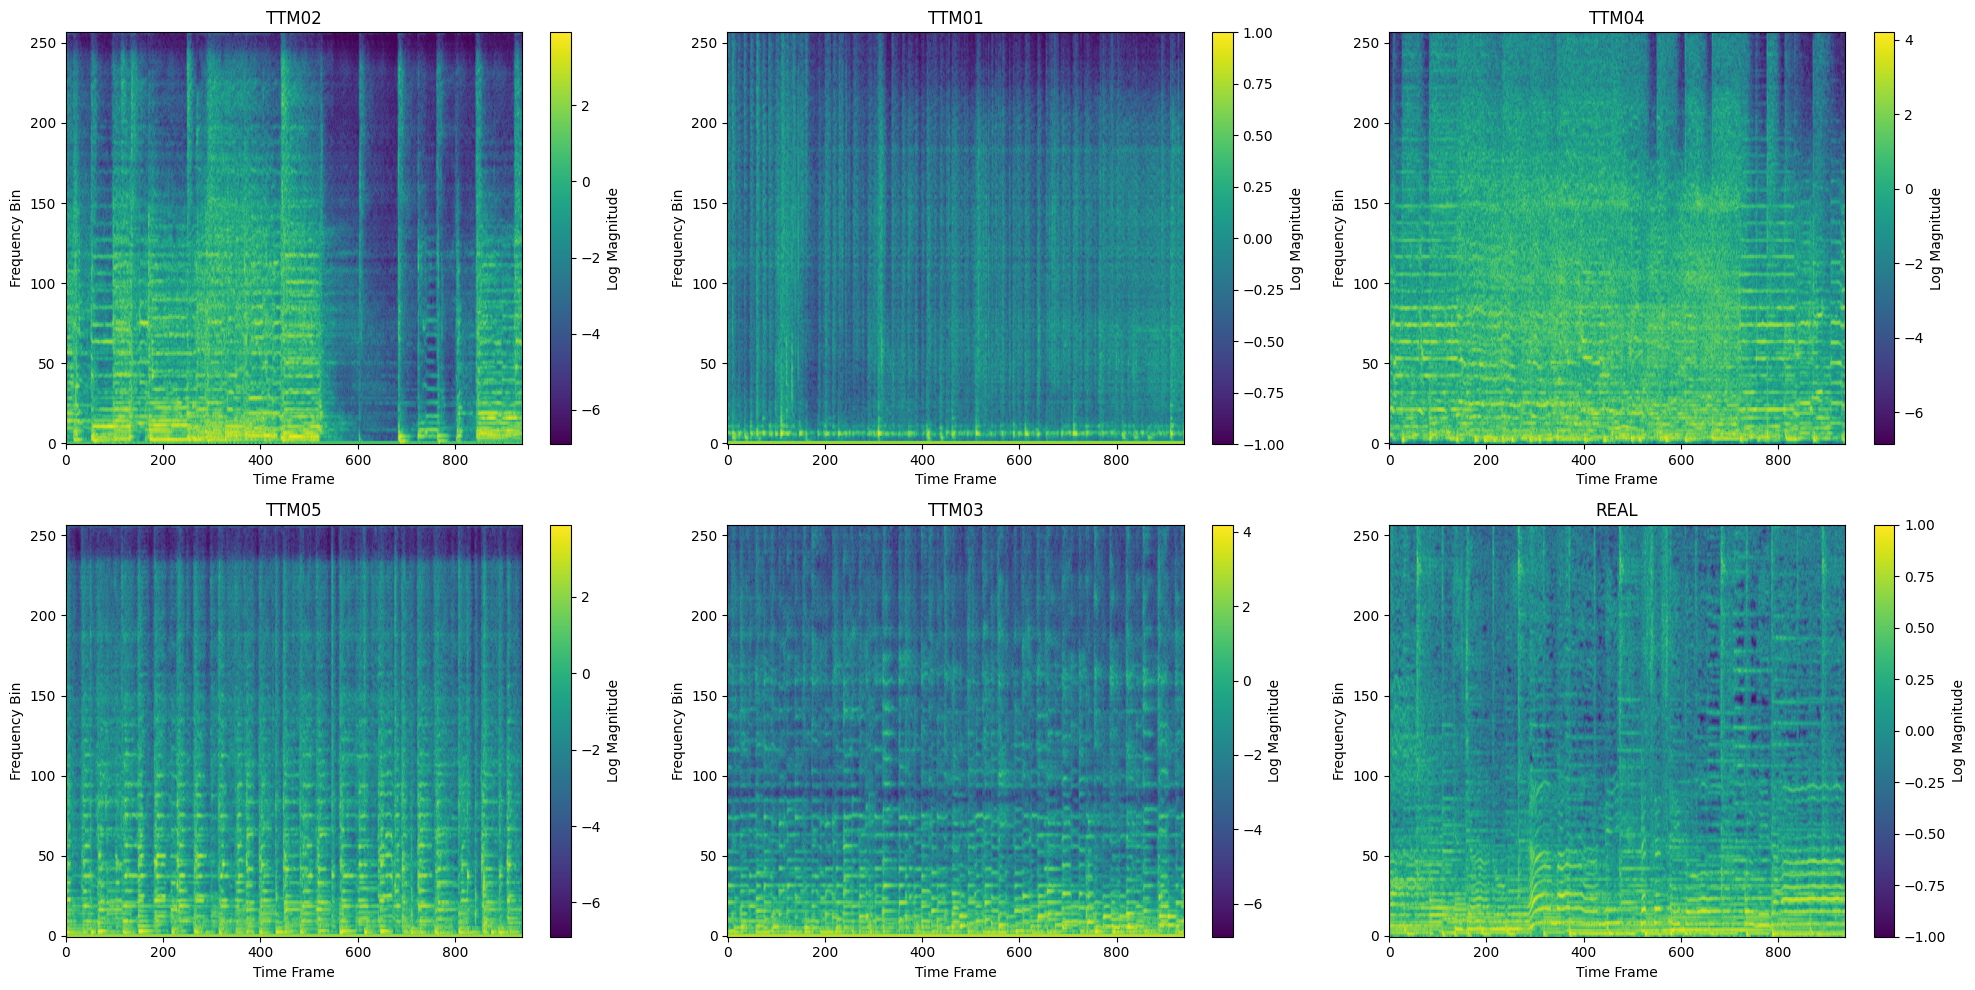

Spectrogram shape: torch.Size([1, 257, 938])


In [4]:
# Create dataset for spectrograms
freq_dataset = MusicDeepFakeDataset(train_set, model_labels, 7.5, feat_type='freq')

# Get one example from each class
classes = ['REAL', 'TTM01', 'TTM02', 'TTM03', 'TTM04', 'TTM05']
examples = {}

for i, (data, label) in enumerate(freq_dataset):
    class_idx = int(label.item())  # Convert float to int
    class_name = classes[class_idx]
    if class_name not in examples:
        examples[class_name] = data
    if len(examples) == len(classes):
        break

# Plot spectrograms
plt.figure(figsize=(20, 10))
for i, (class_name, spec) in enumerate(examples.items(), 1):
    plt.subplot(2, 3, i)
    plt.title(f'{class_name}')
    plt.imshow(spec.squeeze(), aspect='auto', origin='lower')
    plt.colorbar(label='Log Magnitude')
    plt.xlabel('Time Frame')
    plt.ylabel('Frequency Bin')

plt.tight_layout()
plt.show()

# Print shapes for reference
print("Spectrogram shape:", spec.shape)

## Results: confusion matrices for open and closed threshold set of SpecResNet 7.5s model

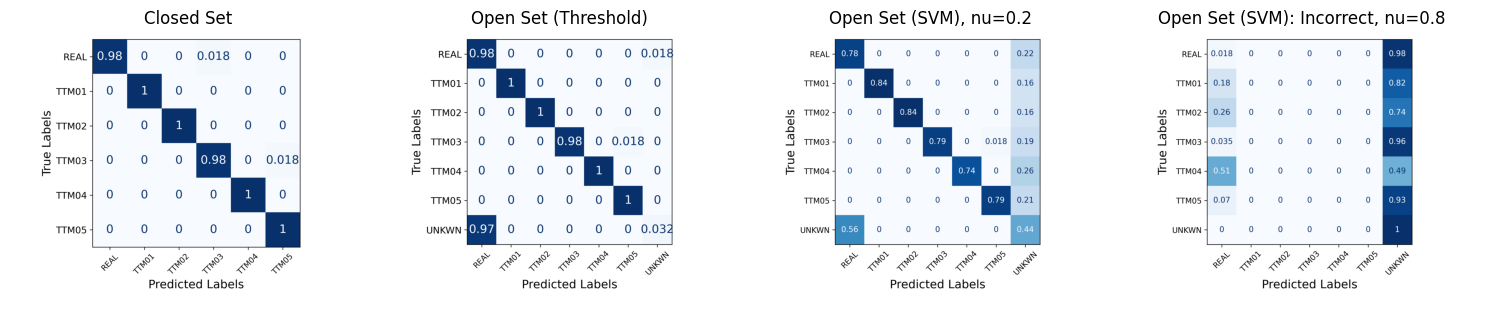

In [6]:
# Load confusion matrix PNGs
cm_closed = mpimg.imread(os.path.join(FIGURES_DIR, 'cm_closed_set_SpecResNet_7.5_sec.png'))
cm_thresh = mpimg.imread(os.path.join(FIGURES_DIR, 'cm_open_set_thresh_SpecResNet_7.5_sec.png'))
cm_svm_correct_nu02 = mpimg.imread(os.path.join(FIGURES_DIR, 'cm_open_set_svm_SpecResNet_7.5_sec_correctnu02.png'))
cm_svm_incorrect_nu08 = mpimg.imread(os.path.join(FIGURES_DIR, 'cm_open_set_svm_SpecResNet_7.5_sec_incorrectnu08.png'))


# Display them
plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(cm_closed)
plt.title('Closed Set')
plt.axis('off')

plt.subplot(142)
plt.imshow(cm_thresh)
plt.title('Open Set (Threshold)')
plt.axis('off')

plt.subplot(143)
plt.imshow(cm_svm_correct_nu02)
plt.title('Open Set (SVM), nu=0.2')
plt.axis('off')

plt.subplot(144)
plt.imshow(cm_svm_incorrect_nu08)
plt.title('Open Set (SVM): Incorrect, nu=0.8')
plt.axis('off')

plt.tight_layout()
plt.show()

## Final Accuracy Metrics:

| Classification | ACC_B | Precision | Recall | F1 Score |
|----------------|-------|-----------|---------|-----------|
| Closed | 0.99 | 0.99 | 0.99 | 0.99 |
| Open (Threshold) | 0.86 | 0.87 | 0.86 | 0.81 |
| Open (SVM) | 0.75 | 0.83 | 0.75 | 0.78 |

Open SVM scores are very dependent on `nu` hyperparamter in SVM. It basically decides ahead of time what the proportion of outliers in the data will be.

The paper had a value of 0.5, and had their values hovering around 0.5, in our case we had the value at 0.2, and the scores were hovering around 0.8 because of the predecided outlier proportion.

## Solution to incorrect SVM scores:
Proper tensor dimension handling:
- Before: Working with shape [1, 1, 6], leading to incorrect argmax prediction
- After: Using `squeeze()` to get clean [6] shape for logits
  - Removed extra dimensions that were causing confusion
  - Made tensor shape match what ResNet was actually predicting
  - Allowed proper probability calculations
Correct argmax dimension
- Before: `argmax(dim=1)` on wrong shape gave all zeros
- After: `argmax(dim=0)` on squeezed tensor
  - Properly identified highest logit (non-scaled softmax probabilities)
  - Preserved ResNet's actual class predictions
  - Matched the model's intended output structure